Fetch data from json and remove columns which are not required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests

# Fetch data from JSON format web link
response = requests.get('http://www.qts.iitkgp.ac.in/last/1/1000000')
data = response.json()

# Load data into a Pandas DataFrame
df = pd.DataFrame(data)


In [2]:
df

,Board_id,Humidity,Mac_id,Reading_id,Temperature,Time,co2ppm,ethylene1
0,1,100.00,7c:9e:bd:f3:b5:08,235319,20.94883,2021-09-03 10:27:34.522067,587.0,4.94
1,1,100.00,7c:9e:bd:f3:b5:08,235318,20.93225,2021-09-03 10:27:24.132605,587.0,5.52
2,1,100.00,7c:9e:bd:f3:b5:08,235317,20.93225,2021-09-03 10:27:13.758111,586.0,5.60
3,1,100.00,7c:9e:bd:f3:b5:08,235316,20.91567,2021-09-03 10:27:03.382006,586.0,5.69
4,1,100.00,7c:9e:bd:f3:b5:08,235315,20.94883,2021-09-03 10:26:52.989200,586.0,6.19
...,...,...,...,...,...,...,...,...
235312,1,69.42,7c:9e:bd:f3:b5:08,7,21.92000,2021-08-04 12:55:24.868137,1157.0,0.00
235313,1,69.43,7c:9e:bd:f3:b5:08,6,21.93000,2021-08-04 12:55:14.494439,1161.0,0.00
235314,1,69.26,7c:9e:bd:f3:b5:08,5,21.95000,2021-08-04 12:55:04.136141,1164.0,0.00
235315,1,69.23,7c:9e:bd:f3:b5:08,4,21.99000,2021-08-04 12:54:53.769282,1167.0,0.00


In [3]:
# Remove columns
df = df.drop(['Mac_id', 'Reading_id', 'Board_id', 'Humidity', 'co2ppm', 'ethylene1'], axis=1)

# Check if the values in the Temperature column are already in Kelvin, if not convert to deg. Celcius
if df['Temperature'].max() < 273.16:
    # If not, add 273.16 to the values
    df['Temp_Kelvin'] = df['Temperature'] + 273.16
    
# Calculate age of sensor in hours
last_time = pd.to_datetime(df['Time'].iloc[-1])
df['Age_hours'] = (pd.to_datetime(df['Time']) - last_time).astype('timedelta64[h]')

In [4]:
df

,Temperature,Time,Temp_Kelvin,Age_hours
0,20.94883,2021-09-03 10:27:34.522067,294.10883,717.0
1,20.93225,2021-09-03 10:27:24.132605,294.09225,717.0
2,20.93225,2021-09-03 10:27:13.758111,294.09225,717.0
3,20.91567,2021-09-03 10:27:03.382006,294.07567,717.0
4,20.94883,2021-09-03 10:26:52.989200,294.10883,717.0
...,...,...,...,...
235312,21.92000,2021-08-04 12:55:24.868137,295.08000,0.0
235313,21.93000,2021-08-04 12:55:14.494439,295.09000,0.0
235314,21.95000,2021-08-04 12:55:04.136141,295.11000,0.0
235315,21.99000,2021-08-04 12:54:53.769282,295.15000,0.0


Arrhenius Model for thermal failure of sensor

In [5]:
# Constants
A = 9990 # (M^-1*s^-1) The constant A is a scaling factor
dH = 1 # (in ev) The value of dH depends on the failure mechanism and the materials involved, and typically ranges from 0.3 or 0.4 up to 1.5.
k = 8.617e-5 # (in ev/K) Boltzman's Constant

# Evaluate Arrhenius equation for each temperature
rate_of_failure = A * np.exp(-dH / (k * df.iloc[:, 2]))

# Add new column for rate_of_failure
df['rate_of_failure'] = rate_of_failure

In [6]:
df

,Temperature,Time,Temp_Kelvin,Age_hours,rate_of_failure
0,20.94883,2021-09-03 10:27:34.522067,294.10883,717.0,7.296981e-14
1,20.93225,2021-09-03 10:27:24.132605,294.09225,717.0,7.280767e-14
2,20.93225,2021-09-03 10:27:13.758111,294.09225,717.0,7.280767e-14
3,20.91567,2021-09-03 10:27:03.382006,294.07567,717.0,7.264587e-14
4,20.94883,2021-09-03 10:26:52.989200,294.10883,717.0,7.296981e-14
...,...,...,...,...,...
235312,21.92000,2021-08-04 12:55:24.868137,295.08000,0.0,8.308886e-14
235313,21.93000,2021-08-04 12:55:14.494439,295.09000,0.0,8.319967e-14
235314,21.95000,2021-08-04 12:55:04.136141,295.11000,0.0,8.342171e-14
235315,21.99000,2021-08-04 12:54:53.769282,295.15000,0.0,8.386748e-14


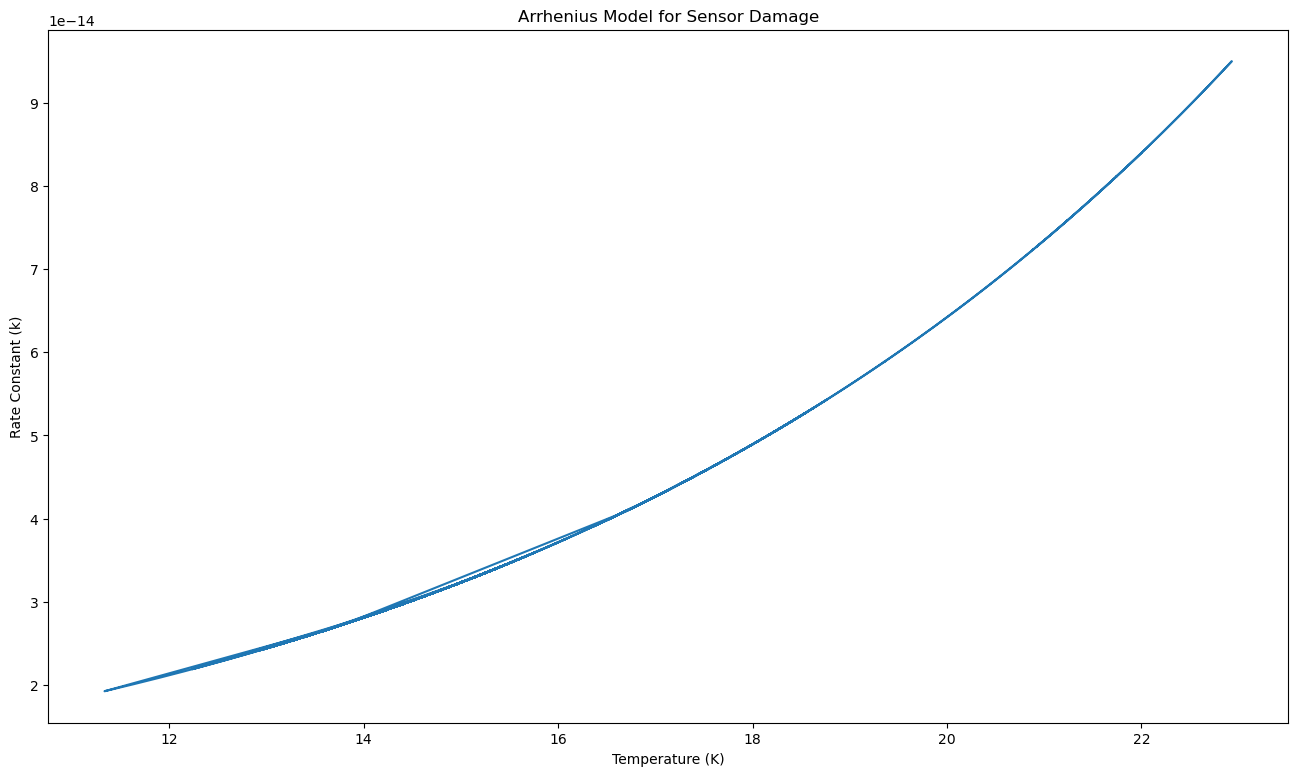

In [7]:
# Plot graph of temperature vs. rate constant
plt.figure(figsize=(16, 9))
plt.plot(df.iloc[:, 0], rate_of_failure)
plt.xlabel('Temperature (K)')
plt.ylabel('Rate Constant (k)')
plt.title('Arrhenius Model for Sensor Damage')
plt.show()

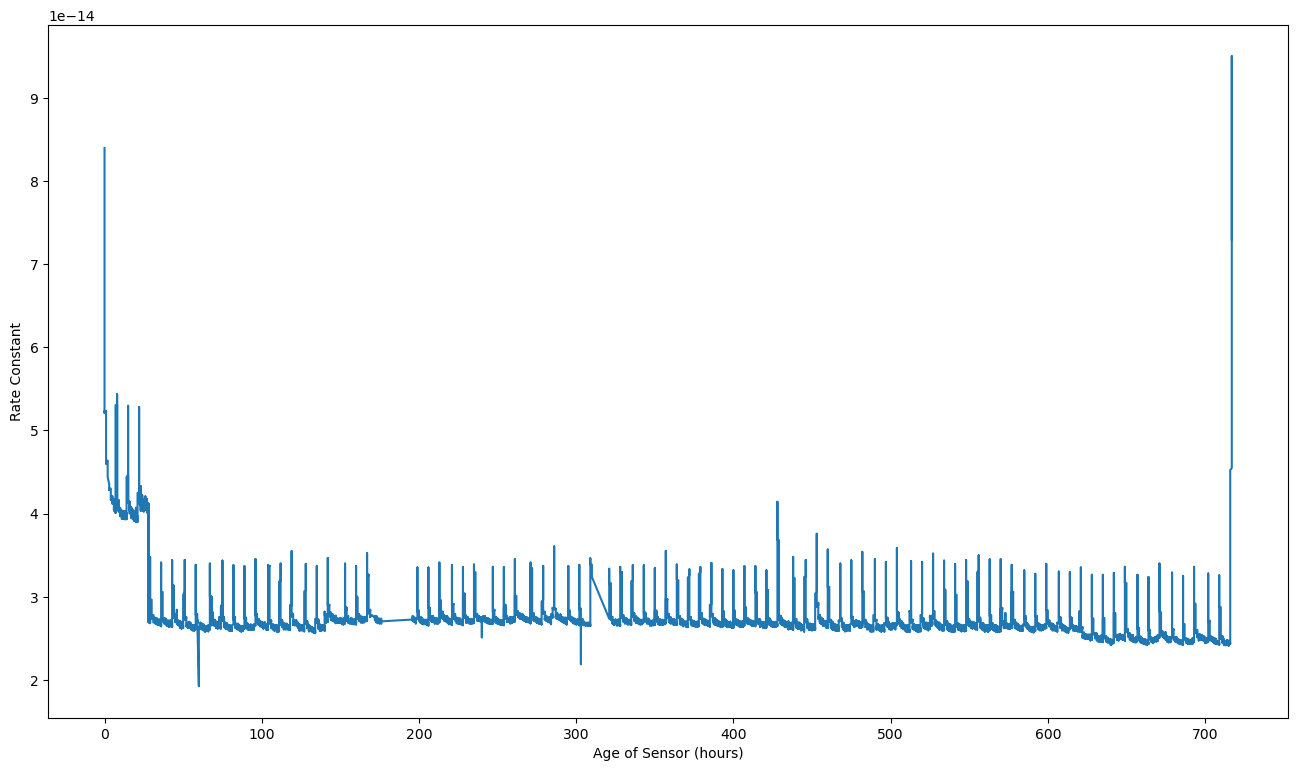

In [8]:
# Plot graph of age vs. rate constant
plt.figure(figsize=(16, 9))
plt.plot(df['Age_hours'], df['rate_of_failure'])
plt.xlabel('Age of Sensor (hours)')
plt.ylabel('Rate Constant')
plt.show()

WMA of RoF

In [9]:
# Define the number of rows to take into account for the moving average
window_size = 180

# Define the weights to be used for the moving average
weights = np.linspace(0, 1, window_size)

# Define a list to store the weighted moving averages
weighted_moving_averages = []

# Loop through the rows of the DataFrame
for i in range(len(df)):
    if i < window_size:
        # For the first window_size rows, take the mean of the available values
        weighted_moving_averages.append(df.iloc[:i+1]['rate_of_failure'].mean())
    else:
        # For the remaining rows, take the weighted mean of the last window_size values
        weighted_moving_averages.append(np.average(df.iloc[i-window_size+1:i+1]['rate_of_failure'], weights=weights))

# Add the new column to the DataFrame
df['WMA_RoF'] = weighted_moving_averages

In [10]:
df

,Temperature,Time,Temp_Kelvin,Age_hours,rate_of_failure,WMA_RoF
0,20.94883,2021-09-03 10:27:34.522067,294.10883,717.0,7.296981e-14,7.296981e-14
1,20.93225,2021-09-03 10:27:24.132605,294.09225,717.0,7.280767e-14,7.288874e-14
2,20.93225,2021-09-03 10:27:13.758111,294.09225,717.0,7.280767e-14,7.286172e-14
3,20.91567,2021-09-03 10:27:03.382006,294.07567,717.0,7.264587e-14,7.280776e-14
4,20.94883,2021-09-03 10:26:52.989200,294.10883,717.0,7.296981e-14,7.284017e-14
...,...,...,...,...,...,...
235312,21.92000,2021-08-04 12:55:24.868137,295.08000,0.0,8.308886e-14,7.336918e-14
235313,21.93000,2021-08-04 12:55:14.494439,295.09000,0.0,8.319967e-14,7.352355e-14
235314,21.95000,2021-08-04 12:55:04.136141,295.11000,0.0,8.342171e-14,7.367893e-14
235315,21.99000,2021-08-04 12:54:53.769282,295.15000,0.0,8.386748e-14,7.383779e-14


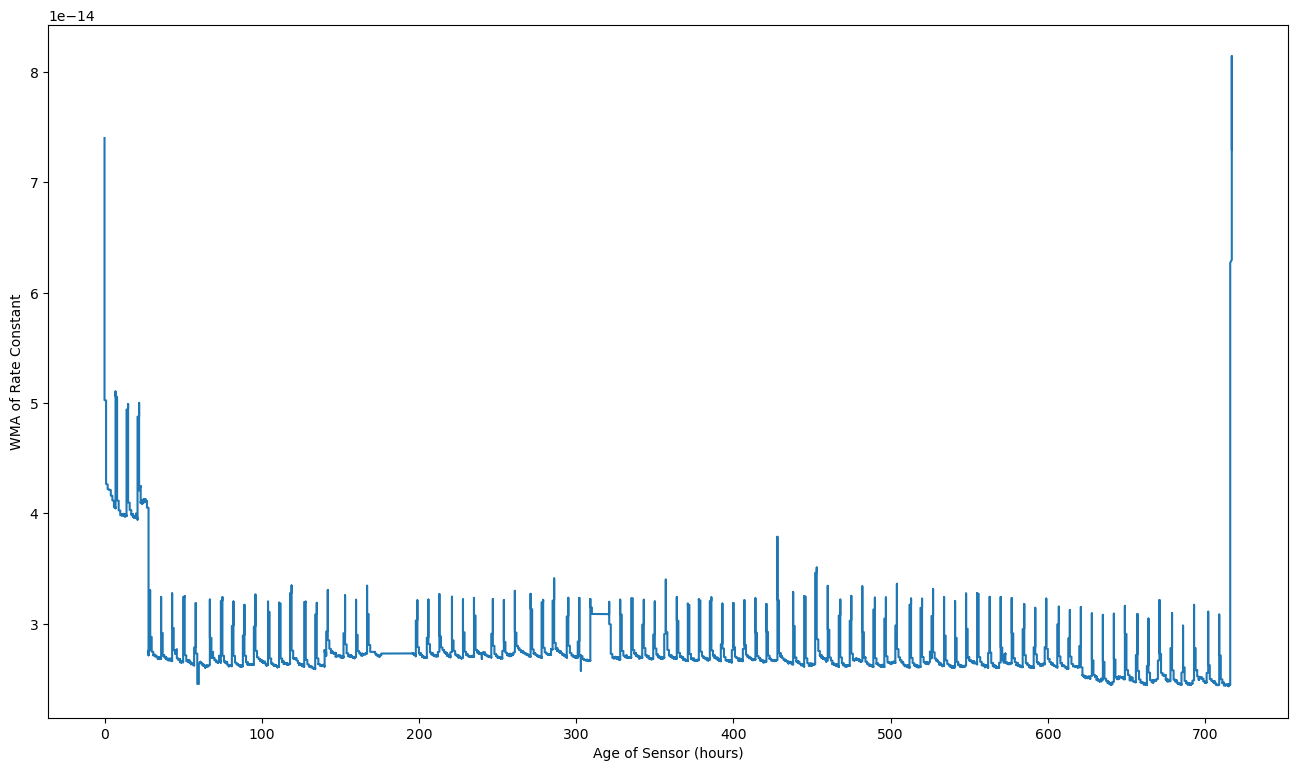

In [11]:
# Plot graph of age vs. rate constant
plt.figure(figsize=(16, 9))
plt.plot(df['Age_hours'], df['WMA_RoF'])
plt.xlabel('Age of Sensor (hours)')
plt.ylabel('WMA of Rate Constant')
plt.show()

Plot histogram of WMA_RoF

<AxesSubplot:xlabel='WMA_RoF', ylabel='Count'>

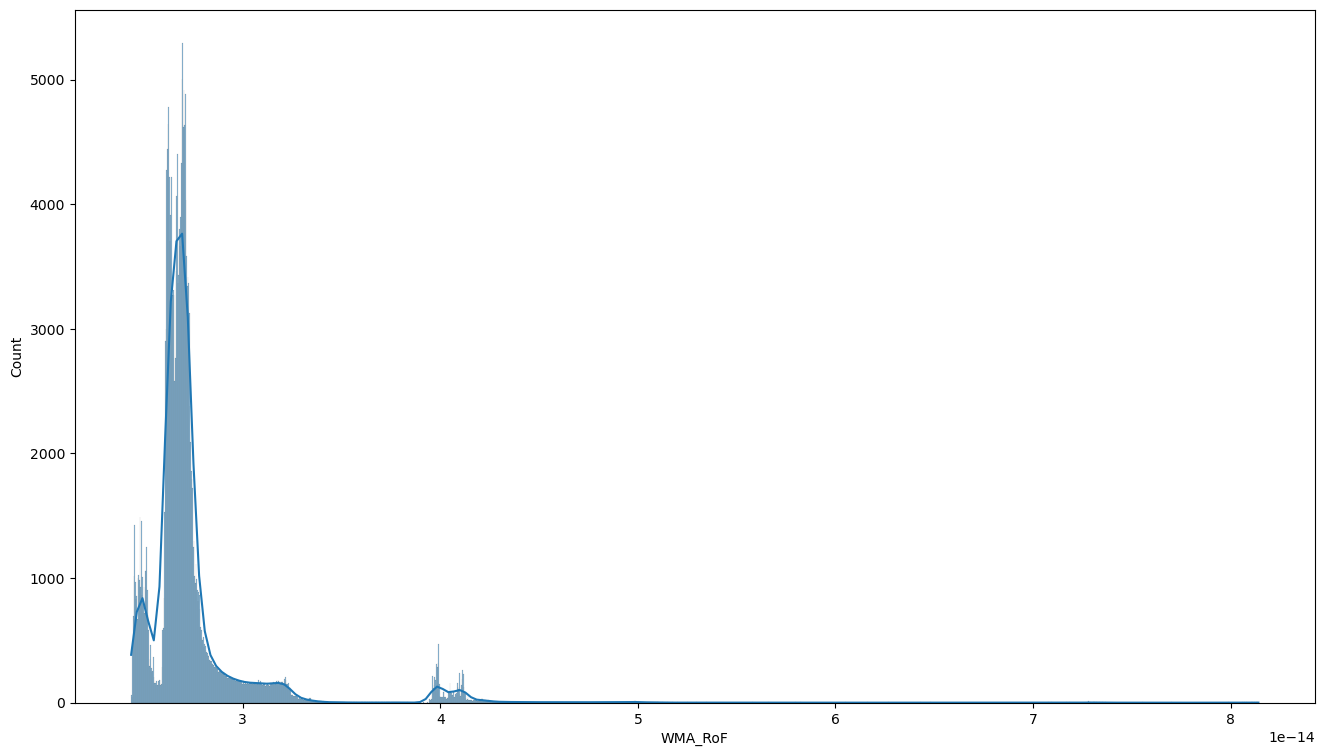

In [12]:
import seaborn as sns

plt.figure(figsize=(16, 9))
sns.histplot(df['WMA_RoF'], kde=True)

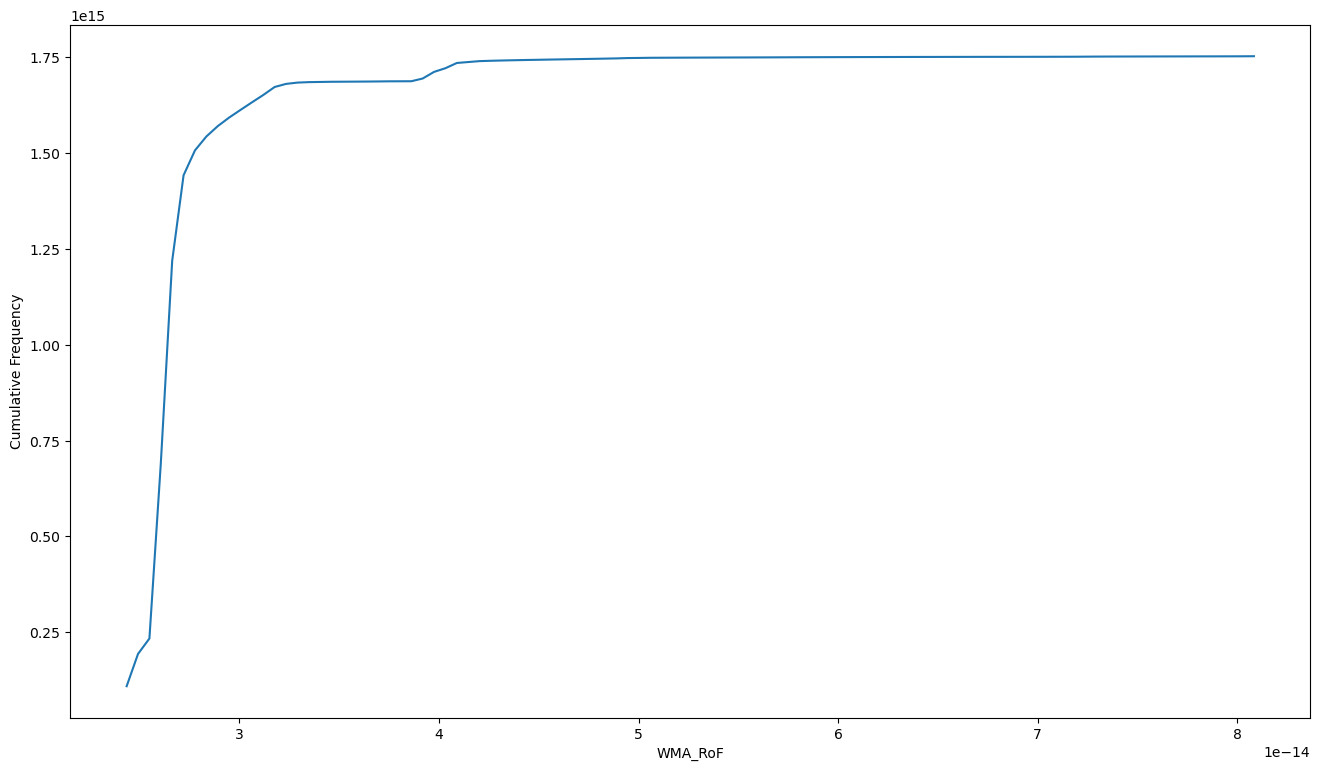

In [13]:
# Create a cumulative frequency distribution
cumulative = np.cumsum(np.histogram(df['WMA_RoF'], bins=100, density=True)[0])

# Plot the cumulative distribution
plt.figure(figsize=(16, 9))
plt.plot(np.histogram(df['WMA_RoF'], bins=100, density=True)[1][:-1], cumulative)

# Set the x and y axis labels
plt.xlabel('WMA_RoF')
plt.ylabel('Cumulative Frequency')

# Show the plot
plt.show()


In [14]:
threshold = 3.875e-14
df['Fault'] = np.where(df['WMA_RoF'] > threshold, 1, 0)

In [15]:
df

,Temperature,Time,Temp_Kelvin,Age_hours,rate_of_failure,WMA_RoF,Fault
0,20.94883,2021-09-03 10:27:34.522067,294.10883,717.0,7.296981e-14,7.296981e-14,1
1,20.93225,2021-09-03 10:27:24.132605,294.09225,717.0,7.280767e-14,7.288874e-14,1
2,20.93225,2021-09-03 10:27:13.758111,294.09225,717.0,7.280767e-14,7.286172e-14,1
3,20.91567,2021-09-03 10:27:03.382006,294.07567,717.0,7.264587e-14,7.280776e-14,1
4,20.94883,2021-09-03 10:26:52.989200,294.10883,717.0,7.296981e-14,7.284017e-14,1
...,...,...,...,...,...,...,...
235312,21.92000,2021-08-04 12:55:24.868137,295.08000,0.0,8.308886e-14,7.336918e-14,1
235313,21.93000,2021-08-04 12:55:14.494439,295.09000,0.0,8.319967e-14,7.352355e-14,1
235314,21.95000,2021-08-04 12:55:04.136141,295.11000,0.0,8.342171e-14,7.367893e-14,1
235315,21.99000,2021-08-04 12:54:53.769282,295.15000,0.0,8.386748e-14,7.383779e-14,1


In [16]:
min_value = df['Fault'].min()
max_value = df['Fault'].max()
first_min_index = df['Fault'].idxmin()
last_max_index = df['Fault'].index[df['Fault']==max_value][-1]
range_of_rows = (first_min_index, last_max_index)
print(range_of_rows)

(284, 235316)


In [17]:
# Filter the rows where sensor failure was detected
fault = df.query("`Fault` == 1")

# Print the number of rows where failure was detected
print(f"Number of Faults detected: {len(fault)}")

Number of Faults detected: 8774


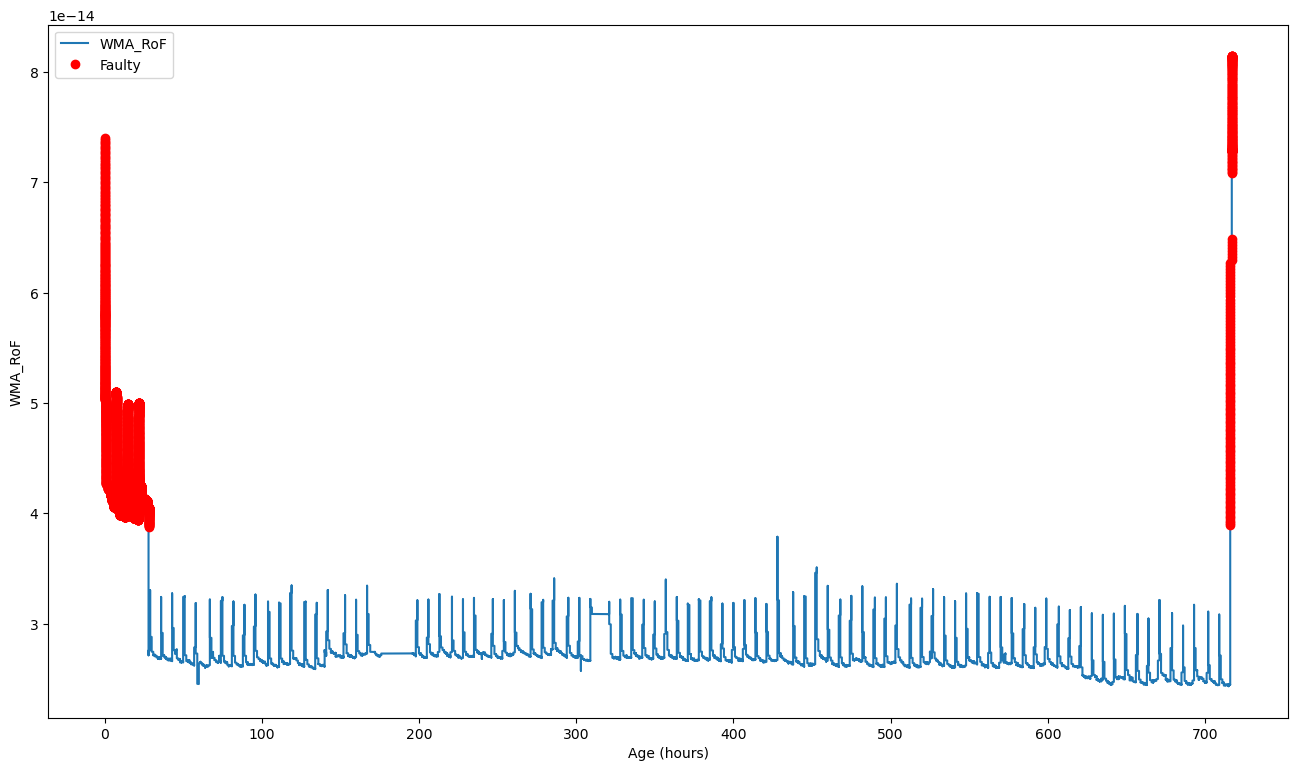

In [18]:
# Plot the weighted moving average vs time
plt.figure(figsize=(16, 9))
plt.plot(df['Age_hours'], df['WMA_RoF'], label='WMA_RoF')

# Add red markers when Fault == 1
faulty_times = df.loc[df['Fault'] == 1, 'Age_hours']
faulty_values = df.loc[df['Fault'] == 1, 'WMA_RoF']
plt.plot(faulty_times, faulty_values, 'ro', label='Faulty')

# Add legend and axis labels
plt.legend()
plt.xlabel('Age (hours)')
plt.ylabel('WMA_RoF')
plt.show()

SVM (Feature: Temperature, Class: Fault)

In [19]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split into features and classes
X = df[['Temperature']]
y = df['Fault']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an SVM classifier with a linear kernel
svm = SVC(kernel='linear', C=1, gamma='scale')

# Fit the classifier to the training data
svm.fit(X_train, y_train)

# Make predictions on the test data
y_pred = svm.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9987463878973313


Save the trained SVM model

In [21]:
import pickle

# Save the classifier to a file
with open("C:\\Users\\abhis\\Downloads\\svm_model_sensor_failure.pkl", 'wb') as file:
    pickle.dump(svm, file)

Prediction for new data

In [22]:
# Fetch data from JSON format web link
response = requests.get('http://www.qts.iitkgp.ac.in/last/1/100')
data_new = response.json()

# Load data into a Pandas DataFrame
df_new = pd.DataFrame(data_new)

# Remove columns
df_new = df_new.drop(['Mac_id', 'Reading_id', 'Board_id', 'Humidity', 'co2ppm', 'ethylene1'], axis=1)

# Fetch data from JSON format web link
response = requests.get('http://www.qts.iitkgp.ac.in/last/1/100')
data_new = response.json()

# Load data into a Pandas DataFrame
df_new = pd.DataFrame(data_new)

# Remove columns
df_new = df_new.drop(['Mac_id', 'Reading_id', 'Board_id', 'Humidity', 'co2ppm', 'ethylene1'], axis=1)
  
# Calculate age of sensor in hours
last_time = pd.to_datetime(df_new['Time'].iloc[-1])
df_new['Age_hours'] = (pd.to_datetime(df_new['Time']) - last_time).astype('timedelta64[h]')

In [23]:
# Select the feature column
X_new = df_new[['Temperature']]

# Load the trained SVM classifier
with open("C:\\Users\\abhis\\Downloads\\svm_model_sensor_failure.pkl", 'rb') as file:
    svm = pickle.load(file)

# Make predictions on the new data
y_pred = svm.predict(X_new)

# Print the predicted classes
print(y_pred)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


Counting the number of instances for each class

In [24]:
# Count the number of instances for each class
class_counts = pd.Series(y_pred).value_counts()

# Print the class counts
print(class_counts)

1    100
dtype: int64


# GUI

In [ ]:
from flask import Flask, render_template
import io
import base64
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

app = Flask(__name__, template_folder="C:/Users/abhis/Downloads/templates")


@app.route('/')
def index():
    # Fetch data from JSON format web link
    response = requests.get('http://www.qts.iitkgp.ac.in/last/1/100')
    data_new = response.json()

    # Load data into a Pandas DataFrame
    df_new = pd.DataFrame(data_new)

    # Remove columns
    df_new = df_new.drop(['Mac_id', 'Reading_id', 'Board_id', 'Humidity', 'co2ppm', 'ethylene1'], axis=1)

    # Calculate age of sensor in hours
    last_time = pd.to_datetime(df_new['Time'].iloc[-1])
    df_new['Age_hours'] = (pd.to_datetime(df_new['Time']) - last_time).astype('timedelta64[h]')

    # Select the feature column
    X_new = df_new[['Temperature']]

    # Load the trained SVM classifier
    with open("C:\\Users\\abhis\\Downloads\\svm_model_sensor_failure.pkl", 'rb') as file:
        svm = pickle.load(file)

    # Make predictions on the new data
    y_pred = svm.predict(X_new)

    # Create the figure and axes for the plot
    fig = Figure(figsize=(5, 2), dpi=300)
    ax = fig.add_subplot(111)

    # Convert the Time column to datetime and plot the data (only the first q rows)
    q = 10
    time = pd.to_datetime(df_new['Time'])
    ax.plot(time[q:], df_new['Temperature'][q:], color='blue')
    ax.scatter(time[q:][y_pred[q:] == 1], df_new['Temperature'][q:][y_pred[q:] == 1], color='red')

    # Add labels and title
    ax.set_xlabel('Time')
    ax.set_ylabel('Temperature')
    ax.set_title('Temperature vs Time')

    # Save the figure to a PNG image in memory
    img = io.BytesIO()
    fig.savefig(img, format='png')
    img.seek(0)

    # Encode the image data as a base64 string
    plot_url = base64.b64encode(img.getvalue()).decode()

    # Render the HTML template and pass the plot URL
    return render_template('index.html', plot_url=plot_url)

if __name__ == '__main__':
    app.run()

In [ ]:
from flask import Flask, render_template
import io
import base64
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

app = Flask(__name__, template_folder="C:/Users/abhis/Downloads/templates")


@app.route('/')
def index():
    # Fetch data from JSON format web link
    response = requests.get('http://www.qts.iitkgp.ac.in/last/1/1000')
    data_new = response.json()

    # Load data into a Pandas DataFrame
    df_new = pd.DataFrame(data_new)

    # Remove columns
    df_new = df_new.drop(['Mac_id', 'Reading_id', 'Board_id', 'Humidity', 'co2ppm', 'ethylene1'], axis=1)

    # Calculate age of sensor in hours
    last_time = pd.to_datetime(df_new['Time'].iloc[-1])
    df_new['Age_hours'] = (pd.to_datetime(df_new['Time']) - last_time).astype('timedelta64[h]')

    # Select the feature column
    X_new = df_new[['Temperature']]

    # Load the trained SVM classifier
    with open("C:\\Users\\abhis\\Downloads\\svm_model_sensor_failure.pkl", 'rb') as file:
        svm = pickle.load(file)

    # Make predictions on the new data
    y_pred = svm.predict(X_new)

    # Create the figure and axes for the plot
    fig = Figure(figsize=(5, 2), dpi=300)
    ax = fig.add_subplot(111)

    # Convert the Time column to datetime and plot the data (only the first q rows)
    q = 234
    time = pd.to_datetime(df_new['Time'])
    ax.plot(time[q:335], df_new['Temperature'][q:335], color='blue')
    ax.scatter(time[q:335][y_pred[q:335] == 1], df_new['Temperature'][q:335][y_pred[q:335] == 1], color='red')


    # Add labels and title
    ax.set_xlabel('Time')
    ax.set_ylabel('Temperature')
    ax.set_title('Sensor DHT22')

    # Save the figure to a PNG image in memory
    img = io.BytesIO()
    fig.savefig(img, format='png')
    img.seek(0)

    # Encode the image data as a base64 string
    plot_url = base64.b64encode(img.getvalue()).decode()

    # Render the HTML template and pass the plot URL
    return render_template('index.html', plot_url=plot_url)

if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [15/Apr/2023 10:31:37] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [15/Apr/2023 12:30:53] "GET / HTTP/1.1" 200 -
